In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

from nupic.research.frameworks.continuous_learning.utils import (
    clear_labels,
    freeze_output_layer,
    split_inds,
)
    
from exp_lesparse import LeSparseNet

import os

from nupic.research.frameworks.pytorch.model_utils import evaluate_model
from nupic.research.frameworks.continuous_learning.dendrite_layers import (
    DendriteLayer, DendriteInput, DendriteOutput
)
from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [23]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
exp = "sparseCNN2"

config = config_init[exp]
config["name"] = exp
config["use_dendrites"] = False
config["use_batch_norm"] = True
config["cnn_out_channels"] = (256, 256)
config["cnn_percent_on"] = (1., 1.) # (0.2, 0.2)
config["cnn_weight_sparsity"] = (1., 1.) #(0.5, 0.5)
config["dendrites_per_cell"] = 2
config["batch_size"] = 64
# config["momentum"] = 0.0
experiment = ContinuousSpeechExperiment(config=config)

Creating optimizer with learning rate= 0.01


In [24]:
modules, indices = [], []
module_sizes = [256, 256, 1000, 11]
cnt = 0
for module in experiment.model:
    if hasattr(module, "weight_sparsity"):
        inds = split_inds(module, 5, module_sizes[cnt])
        final_inds = [np.delete(np.arange(module_sizes[cnt]), kidx) for kidx in inds]
        modules.append(module)
        indices.append(final_inds)
        
        cnt += 1

In [ ]:
train_inds = np.random.permutation(np.arange(1,11)).reshape(5,2)
for j in range(len(train_inds)):
    temp_inds = [k[j] for k in indices]
    experiment.train(1, train_inds[j], freeze_modules=modules[:-1], module_inds=temp_inds[:-1],
                    freeze_output=True, output_indices=clear_labels(train_inds[j]),
                     layer_type="kwinner")

In [ ]:
[experiment.test_class(k)["mean_accuracy"] for k in train_inds.flatten()]

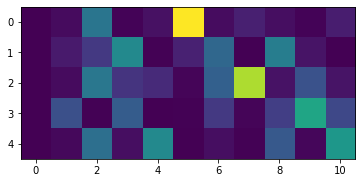

In [21]:
plt.imshow(experiment.running_accuracy)

In [26]:
indices

[[array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  19,  20,  23,  24,  25,  26,  27,  28,  30,  31,
          32,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          48,  49,  50,  52,  55,  56,  58,  59,  60,  61,  63,  64,  65,
          67,  69,  70,  71,  73,  74,  75,  77,  78,  79,  80,  81,  82,
          83,  84,  85,  86,  87,  89,  90,  92,  93,  94,  95,  96,  98,
         100, 101, 102, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115,
         116, 117, 118, 120, 122, 123, 126, 127, 129, 130, 131, 132, 133,
         134, 135, 136, 137, 138, 139, 141, 143, 144, 145, 146, 147, 148,
         150, 151, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 165,
         166, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180,
         183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197,
         198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
         212, 214, 215, 216, 217, 219,

In [130]:
ind = 0
a,b = list(modules[ind].named_parameters())
[a[1].grad[k,...].mean() for k in temp_inds[ind]]

[tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0')]

In [105]:
w = list(experiment.model.named_parameters())
[w[2][1].grad[k,...].mean() for k in temp_inds[2]]

IndexError: index 795 is out of bounds for dimension 0 with size 128

In [88]:
module.parameters()

<generator object Module.parameters at 0x7fbff40bbad0>

In [5]:
def freeze_grads(module, inds):
    with torch.no_grad():
        weight_grads, bias_grads = list(module.parameters())
        if len(weight_grads.shape) > 2:
            [weight_grads.data[index,:,:,:].fill_(0.0) for index in inds]
        else:
            [weight_grads.data[index,:].fill_(0.0) for index in inds]
        [bias_grads.data[index].fill_(0.0) for index in inds]

In [44]:
def train_model(
    model,
    loader,
    optimizer,
    device,
    freeze_modules=None,
    freeze_splits=5,
    freeze_output=False,
    layer_type="dense",
    linear_number=2,
    output_indices=None,
    criterion=F.nll_loss,
    batches_in_epoch=sys.maxsize,
    pre_batch_callback=None,
    post_batch_callback=None,
    progress_bar=None,
    combine_data=False,
):

    model.train()
    # Use asynchronous GPU copies when the memory is pinned
    # See https://pytorch.org/docs/master/notes/cuda.html
    async_gpu = loader.pin_memory
    if progress_bar is not None:
        loader = tqdm(loader, **progress_bar)
        # update progress bar total based on batches_in_epoch
        if batches_in_epoch < len(loader):
            loader.total = batches_in_epoch

    # Check if training with Apex Mixed Precision
    use_amp = hasattr(optimizer, "_amp_stash")
    try:
        from apex import amp
    except ImportError:
        if use_amp:
            raise ImportError(
                "Mixed precision requires NVIDA APEX."
                "Please install apex from https://www.github.com/nvidia/apex")

    t0 = time.time()

    for batch_idx, (data, target) in enumerate(loader):
        if batch_idx >= batches_in_epoch:
            break

        num_images = len(target)
        data = data.to(device, non_blocking=async_gpu)
        target = target.to(device, non_blocking=async_gpu)
        t1 = time.time()

        if pre_batch_callback is not None:
            pre_batch_callback(model=model, batch_idx=batch_idx)

        optimizer.zero_grad()
        if combine_data:
            output = model(data, target)
        else:
            output = model(data)

        loss = criterion(output, target)
        del data, target, output

        t2 = time.time()

        loss.backward()
        
        if freeze_modules is not None:
            for mod_ in freeze_modules:
                module, inds = get_inds(mod_, freeze_splits)
                freeze_grads(module, inds)

        if freeze_output:
            freeze_output_layer(model, output_indices, layer_type=layer_type,
                                linear_number=linear_number)

        t3 = time.time()
        optimizer.step() # step
        t4 = time.time()

        if post_batch_callback is not None:
            time_string = ("Data: {:.3f}s, forward: {:.3f}s, backward: {:.3f}s,"
                           + "weight update: {:.3f}s").format(t1 - t0, t2 - t1, t3 - t2,
                                                              t4 - t3)
            post_batch_callback(model=model, loss=loss.detach(), batch_idx=batch_idx,
                                num_images=num_images, time_string=time_string)
        del loss
        t0 = time.time()

    if progress_bar is not None:
        loader.n = loader.total
        loader.close()


In [166]:
experiment.model

LeSparseNet(
  (cnn1_cnn): SparseWeights2d(
    sparsity=0.85
    (module): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn1_kwinner): KWinners2d(channels=128, local=False, n=0, percent_on=0.12, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_cnn): SparseWeights2d(
    sparsity=0.95
    (module): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2_kwinner): KWinners2d(channels=128, local=False, n=0, percent_on=0.07, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): SparseWeights(
    sparsity=0.8
    (module): Linear(in_features=3200, out_features=1000, bias=True)
  )
  (linear1_kwinners): KWinners(n=1000, percent_on=0.1, boost_strength=1.5, boo

In [30]:
torch.randperm(10)

tensor([7, 3, 4, 9, 5, 6, 8, 2, 1, 0])